# Stochastic Models
André Guerra \
October, 2022 \
andre.guerra@mail.mcgill.ca

This notebook contains theoretical background on the stochastic simulation approach to options price predictions.

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
# CONSTANTS
# 1. Visualization constants
# a. sizing factors
TICKSFONT = 13
TITLEFONT = 15
TEXTFONT = 15
FIGWIDTH = 6.4
FIGHEIGHT = 4.8
LINEWIDTH = 3
ROLLWINDOW = 100
# b. zoom factors
ZOOMIN = 1.5
ZOOMOUT = 10

## Function definitions

In [3]:
def GBM_walks(So, T, r, q, sigma, steps, N):
    """Create Geometric Brownian Motion random walks to simulate stock prices

    Args:
        So (float):     Current stock price
        T (float):      Time to expiration [years]
        r (float):      Risk free interest
        q (float):      Dividend yield
        sigma (float):  Volatility
        steps (int):    Number of integration time steps
        N (int):        Number of trials

    Returns:
        ST (array): stock price at t=T; array size (steps,N)
    """
    
    dt = T/steps
    mu = (r - q)

    ln_ST = np.log(So) +  np.cumsum(((mu - sigma**2/2)*dt +
                                     sigma*np.sqrt(dt)*
                                     np.random.normal(size=(steps,N))),axis=0)
    ST = np.exp(ln_ST)
    return ST

def black_scholes_option(So, K, T, r, q, sigma, type):
    """Black-Scholes option price for CALL and PUT options

    Args:
        So (float):     Current stock price
        K (float):      Strike price
        T (float):      Time to expiration [years]
        r (float):      Risk free interest
        q (float):      Dividend yield
        sigma (float):  Volatility
        type (string):  Type of option ['CALL', 'PUT']

    Returns:
        option_price (float): Predicted option price at expiration
    """
    d1 = (np.log(So/K) + (r + (sigma**2)/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if type == 'CALL':
        option_price = So*norm.cdf(d1) - norm.cdf(d2)*K*np.exp(-r*T)
    elif type == 'PUT':
        option_price = norm.cdf(-d2)*K*np.exp(-r*T) - So*norm.cdf(-d1)
    return option_price


## Compounding Values
Compounded values can be used to describe populations (e.g., growth and decay), or financial systems (e.g., interest growth). Here we use the population examples.

$X_o$ - initial population <br>
$r$ - compounding factor <br>
$n$ - number of compounding periods <br>
$f$ - number of compounding periods in $n$ (e.g., compounded quarterly in a year) <br>
$t$ - compounding period length in years

<u>Population growth</u>

$X_t = X_o(1+r)$ - one period <br>
$X_t = X_o(1+r)(1+r)$ - two periods <br>
$X_t = X_o(1+r)^n$ - $n$ periods <br>
$X_t = X_o(1+\frac{r}{f})^{fn}$ - compounded $f$ times in period $n$

<u>Population decay</u>

$X_t = X_o(1-r)$ - one period <br>
$X_t = X_o(1-r)(1-r)$ - two periods <br>
$X_t = X_o(1-r)^n$ - $n$ periods <br>
$X_t = X_o(1-\frac{r}{f})^{fn}$ - compounded $f$ times in period $n$

In the limit as $f \rightarrow \infty$ we get the definition of the exponential function:

$(1+\frac{r}{f})^f = e^r$

Which means our population model can be expressed as:

$X_t = X_o e^{rt}$

and it derivative is:

$\frac{dX_t}{dt} = rX_t$

In [ ]:
# e^r
r = np.arange(-2,2.1,0.1)
y = np.exp(r)

# approx e^r with (1+r/f)^f as f->infinity
f = 1
y_f_1 = (1+r/f)**(f)
f = 3
y_f_3 = (1+r/f)**(f)
f = 7
y_f_7 = (1+r/f)**(f)
f = 15
y_f_15 = (1+r/f)**(f)

NROWS = 1
NCOLS = 1
f, axs = plt.subplots(nrows=NROWS,ncols=NCOLS,
                      figsize=(NCOLS*FIGWIDTH,NROWS*FIGHEIGHT))
axs.plot(r,y)
axs.plot(r,y_f_1)
axs.plot(r,y_f_3)
axs.plot(r,y_f_7)
axs.plot(r,y_f_15)
axs.legend(['$e^r$','f=1','f=3','f=7','f=15'])

In [ ]:
Xo = 100                # initial population
r = 0.05                # componding rate [0-1]
n = np.arange(0,26,1)   # years

# population growth
X_t_grow = Xo*(1+r)**n
# population decay
X_t_decay = Xo*(1-r)**n

# population at end of compounding period
print("Final population in growth case: " + str(np.round(X_t_grow[-1],2)))
print("Final population in decay case: " + str(np.round(X_t_decay[-1],2)))

# plot the populations
NROWS = 1
NCOLS = 1
f, axs = plt.subplots(nrows=NROWS,ncols=NCOLS,
                      figsize=(NCOLS*FIGWIDTH,NROWS*FIGHEIGHT))
axs.plot(n,X_t_grow)
axs.plot(n,X_t_decay)
axs.legend(['Growth','Decay'])

## Stochastic differential equation for future value predictions

From the population example above:

$\frac{dX_t}{dt} = rX_t$

which is equal to:

$dX_t = rX_tdt$

In the population growth example above, the compounding rate $r$ was constant. It can be a function of time and it may also have a random component, $dW_t$. Here we shift the example to money value to lead us into the Black-Scholes options pricing model. 

Value model. The price, $S$, changes with time, $t$, according to an interest rate, $\mu$, in a model analogous to the population model above.

$dS_t = \mu S_t dt$

### Introduce a random variance, $dR_t$:

$dS_t = S_t(\mu dt + dR_t)$

If the random variance is given by Geometric Brownian Motion (GBM) process, $dB_t$:

$dS_t = S_t(\mu dt + dB_t)$

The GBM process has a mean of zero ($E[dS_t]=0$) and a variance equal to the period ($V[dS_t]=dt$):

$dB_t = N[0,dt]$

You can add a factor to scale the Brownian Motion term, $\sigma$. This is the volatility term:

$dS_t = S_t(\mu dt + \sigma dB_t)$

From this we get the Stochastic Differential Equation (SDE):

$dS_t = \mu S_t dt + \sigma S_t dB_t$

$\mu$ is also known as the drift term, and $\sigma$ as the diffusion term. These may be functions of time ($\mu_t$ and $\sigma_t$), but here they're assumed constant ($\mu$ and $\sigma$).

### Ito Process and Ito Lemma

The stochastic model for $dS_t$ above is an example of an [Ito process](https://en.wikipedia.org/wiki/It%C3%B4_calculus#It%C3%B4_processes).

According to the [Ito's Lemma](https://en.wikipedia.org/wiki/It%C3%B4%27s_lemma), there's a function, $G$, that is a function of the same variables as the original and twice differentiable, and also follows an Ito process. The informal derivaiton is shown below as found on [Wikipedia](https://en.wikipedia.org/wiki/It%C3%B4%27s_lemma#Informal_derivation):

(1) 2nd order truncated Taylor-series expansion of the function $G(x,t)$

$dG(t,x) = \frac{\partial G}{\partial t}dt + \frac{\partial G}{\partial x}dx + \frac{1}{2}\frac{\partial^2 G}{\partial x^2}dx^2$

(2) Substitute $x=S_t$, $dx = dS_t = \mu S_t dt + \sigma S_t dB_t$

$dG(t,S_t) = \frac{\partial G}{\partial t}dt + \frac{\partial G}{\partial S_t}(\mu S_t dt + \sigma S_t dB_t) + \frac{1}{2}\frac{\partial^2 G}{\partial S_t^2}(\mu S_t dt + \sigma S_t dB_t)^2 + ... $

(3) Expand the quadratic term

$(\mu S_t dt + \sigma S_t dB_t)^2 = \mu^2 S_t^2 dt^2 + 2\mu S_t \sigma dB_t + \sigma^2 S_t^2 dB_t^2$

(4) In limit $t \rightarrow 0$, $dt^2$ and $dtdBt$ terms go to zero faster than others. We set these terms to zero, and substitute $dB_t^2 = dt$ (from the [quadratic variance](https://en.wikipedia.org/wiki/Quadratic_variation) of Brownian Motion)

$dG(t,S_t) = \frac{\partial G}{\partial t}dt + \frac{\partial G}{\partial S_t}(\mu S_t dt + \sigma S_t dB_t) + \frac{1}{2}\frac{\partial^2 G}{\partial S_t^2}(\sigma^2 S_t^2 dt)$

(5) Simplify to get the sister model from Ito's Lemma

$dG(t,S_t) = \left ( \frac{\partial G}{\partial t} + \mu \frac{\partial G}{\partial S_t} S_t + \frac{\sigma^2}{2}\frac{\partial^2 G}{\partial S_t^2} S_t^2 \right )dt + \frac{\partial G}{\partial S_t}(\sigma S_t dB_t)$

### Apply Ito's Lemma to Pricing Model, $S_t$

For the purpose of a stock pricing model, we choose $G = ln(S_t)$ so that $G \geq 0$ (since stock prices can't be negative).

Define:

$G = ln(S_t)$

Then we have the partial derivatives of $G$:

$\frac{dG}{dS_t} = \frac{1}{S_t}$

$\frac{\partial^2 G}{\partial S_t^2} = -\frac{1}{S_t^2}$

$\frac{dG}{dt}=0$

Substitute into our sister model from Ito's Lemma above:

$dG(t,S_t) = \left (\mu \frac{1}{S_t} S_t + \frac{\sigma^2}{2}(-\frac{1}{S_t^2})) S_t^2 \right )dt + \frac{1}{S_t}(\sigma S_t dB_t)$

Simplify:

$dG(t,S_t) = \left (\mu - \frac{\sigma^2}{2} \right )dt + (\sigma dB_t)$

Integrate from $t=0$ to $t=T$

$\int_{S_o}^{S_T} dG(t,S_t) \rightarrow ln(S_T) - ln(S_o) = \int_0^T \left (\mu - \frac{\sigma^2}{2} \right )dt + \int_0^T \sigma dB_t $

Simplified:

$ln(S_T) - ln(S_o) = \left (\mu - \frac{\sigma^2}{2} \right )T + \sigma \sqrt{T}$

### Computational Implementation

To define a function to generate random walks in stock price based on the Geometric Brownian Motion SDE equation derived above, we solve for the integral form for $S_T$:

(1) $ln(S_T) = ln(S_o) + \int_0^T \left (\mu - \frac{\sigma^2}{2} \right )dt + \int_0^T \sigma dB_t $

(2) $S_T = exp(ln(S_T))$

This equation is implemented in the function `GBM_walks()` above.

## Geometric Brownian Motion to Predict Stock Prices

Text(0, 0.5, 'Stock Price, $')

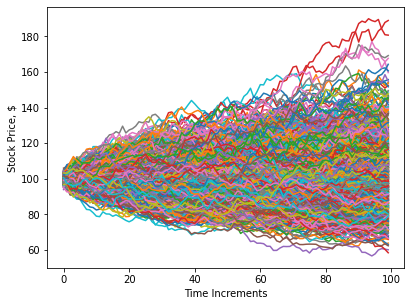

In [4]:
So = 100       # current stock price [$]
K = 110        # strike price, [$]
T = 1/2         # option contract expiration time [years]
r = 0.05        # annual risk free interest [0-1]
q = 0.02        # annual dividend rate [0-1]
sigma = 0.25    # annual volatility [0-1]
steps = 100     # time steps between t=0 and t=T
N = 1000      # number of trials (number of random walks)

# generate random walks of stock prices using Geometric Brownian motion
paths = GBM_walks(So, T, r, q, sigma, steps, N)

# plot the random possible stock price paths leading to option expiration, t=T
NROWS = 1
NCOLS = 1
f, axs = plt.subplots(nrows=NROWS,ncols=NCOLS,
                      figsize=(NCOLS*FIGWIDTH,NROWS*FIGHEIGHT))
axs.plot(paths);
axs.set_xlabel("Time Increments")
axs.set_ylabel("Stock Price, $")

Generate a set of normally distributed random numbers of size N (trials) for each time step. This generates a set of N random walks (stock prices) by generating each step (each time t) as a set of N random numbers.

In [ ]:
np.random.normal(size=(steps,N))

Compare the predicted stock price from GBM and the Black-Scholes call option formula

In [5]:
# 
payoffs = np.maximum(paths[-1]-K, 0)
option_price = np.mean(payoffs)*np.exp(-r*T)
# calculate the option price with the Black-Scholes formula
black_scholes_price = black_scholes_option(So,K,T,r,q,sigma,'CALL')

print("GBM price: " + str(option_price))
print("Black-Scholes price: " + str(black_scholes_price))

GBM price: 3.8138904235497404
Black-Scholes price: 4.225782392960063


Re-run the GBM simulation with higher number of random walks (N=100,000)

In [6]:
N = 1000000    # number of trials (number of random walks)

# generate random walks of stock prices using Geometric Brownian motion
paths = GBM_walks(So, T, r, q, sigma, steps, N)

In [7]:
# 
payoffs = np.maximum(paths[-1]-K, 0)
option_price = np.mean(payoffs)*np.exp(-r*T)
# calculate the option price with the Black-Scholes formula
black_scholes_price = black_scholes_option(So,K,T,r,q,sigma,'CALL')

print("GBM price: " + str(option_price))
print("Black-Scholes price: " + str(black_scholes_price))

GBM price: 3.8613625877598454
Black-Scholes price: 4.225782392960063


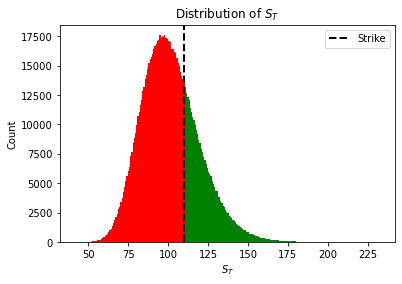

In [8]:
n, bins, patches = plt.hist(paths[-1],bins=250);
for c,p in zip(bins, patches):
    if c > K:
        plt.setp(p,'facecolor','green')
    else:
        plt.setp(p, 'facecolor','red')

plt.axvline(K, color='black', linestyle='dashed', linewidth=2, label="Strike")
plt.title("Distribution of $S_{T}$")
plt.xlabel("$S_{T}$")
plt.ylabel('Count')
plt.legend()